<a href="https://colab.research.google.com/github/vnasserb/Analise_Sinais_EEG/blob/main/An%C3%A1lise_de_Sinais_de_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importação de Bibliotecas**

In [ ]:
import pickle
import pandas as pd
import numpy as np
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, OneSidedSelection
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
from math import floor, ceil
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
import os
import scipy.io
from scipy.special import binom

warnings.filterwarnings("ignore")

## **Instalação do mRMR**

In [ ]:
#Documentação disponível no repositório: https://github.com/smazzanti/mrmr
!pip install mrmr_selection

## **Criação das funções que criam a base de características**

In [ ]:
# Função que define os parâmetros de Hjorth para um sinal de EEG
def Hjorth(signal):

  """
  Activity=m0=σ2a
  Complexity=m2=σd/σa
  Morbidity=m4=σdd/σdm2

  Where:

  σ2x is the mean power of a signal x. That is, its variance, if it’s mean is zero.

  a, d and dd represent the original signal, its first and second derivatives, respectively.
  """

  # Variância do sinal original
  sigma_a_2 = np.var(signal)
  
  # Desvio Padrão do sinal original
  sigma_a = np.sqrt(sigma_a_2)

  # Parâmetro m0
  m0 = sigma_a_2

  # Desvio Padrão da derivada do sinal
  sigma_d = np.sqrt(np.var(np.diff(signal))) 
  
  # Parâmetro m2
  #m2 = sigma_d / sigma_a
  m2 = np.sqrt(np.var(np.diff(signal)) / np.var(signal)) 

  # Desvio Padrão da segunda derivada do sinal
  #sigma_dd = sqrt(var(diff(signal, n=2))) 
  
  # Parâmetro m4
  #m4 = (sigma_dd/sigma_d)/m2
  m4 = np.sqrt(np.var(np.diff(signal, n=2)) / (np.var(np.diff(signal)) * m2))

  return [m0, m2, m4]

# Função que cria os parâmetros Hjorth e HOC
# K: Quantidade de filtros
def Cria_Base_Hjorth_HOC(Arquivos, K = 12):

  Data = []

  # Para cada um dos arquivos
  for f in range(len(Arquivos)):

    # Abrir o arquivo .mat, transformá-lo em numpy array
    EEG = scipy.io.loadmat(Arquivos[f])['data']

    # Vetor que irá armazenar os valores de Dk
    D = []

    # Para cada k, onde 1 <= k <= K
    for k in range(1,K+1):

      # Número de amostras = Número de colunas da Matriz
      N = EEG.shape[1]              

      # Quantidade de canais = Número de linhas da Matriz                                            
      canais = EEG.shape[0]      

      # Matriz canais x (N - k) de zeros                                       
      Z = np.zeros(canais * (N - k)).reshape(canais , (N - k))                  
      
      # Para cada 1 <= j <= k
      for j in range(1,k+1):

        # Calcular os parâmetros HOC para cada canal
        # binom calcula o binômio de Newton para dois valores inteiros
        termo = binom(k - 1, j - 1) * ((-1) ** (j-1)) * EEG

        # A matriz deve ter dimensões canais x (N - k) para a soma ocorrer corretamente
        Z = Z + termo[0:canais,  k-j+1 : N-j+1]

      # Função que transforma os valores em binários
      Binario = np.vectorize(lambda x: 1 if x > 0 else 0)

      # Transformação do vetor resultante do somatório em valores binários
      X = Binario(Z)

      # Contagem da quantidade de vezes que a função toca o 0 em cada canal 
      # Dk é um vetor de dimensão 1 x canais, onde Dk[i] é o número de vezes que o sinal do i-ésimo canal toca o 0
      # A função diff calcula a diferença entre elementos de duas posições consecutivas do vetor
      # A função abs calcula o valor absoluto de todos os elementos do vetor
      # A função sum calcula a soma de todos os elementos do vetor. O argumento axis = 1 define que deve ser feita a soma de cada linha da matriz
      Dk = np.sum(np.abs(np.diff(X)), axis = 1)

      # Adição de Dk ao vetor de Ds
      D.append(Dk)

    # D é um vetor de dimensão k x canais, então deve ser transformado em um vetor 1 x (k * canais)
    Parametros_HOC = np.array(D).reshape(K * canais).tolist()

    # Cálculo dos parâmetros de Hjorth para cada canal
    Parametros_Hjorth = list(map(Hjorth, EEG.tolist()))

    # Transformação de uma lista de listas em uma lista 1D
    Parametros_Hjorth = [item for sublist in Parametros_Hjorth for item in sublist]

    # Adicionar os parâmetros para cada uma das listas dependendo do número do vídeo
    # 1: Positivo e 0: Negativo
    if 'v1' in Arquivos[f] or 'v3' in Arquivos[f] or 'v6' in Arquivos[f]:
      Data.append([1] + Parametros_HOC + Parametros_Hjorth)
    else:
      Data.append([0] + Parametros_HOC + Parametros_Hjorth)

  return pd.DataFrame(Data)

## **Criação da base de características**

In [ ]:
# Caminho dos arquivos .mat no Drive
path = "/content/drive/MyDrive/PGC"

# Utilização da função map para criar o caminho completo para cada um dos arquivos
# Ex. O dataset h1_v1_a_AR.mat aparecerá como /content/drive/MyDrive/PGC/h1_v1_a_AR.mat
Arquivos = list(map(lambda x: path + "/" + x, os.listdir(path)))

# Criação do Dataset
"""
Dataset = []
for i in range(8,13,1):
  Dataset.append(Cria_Base_Hjorth_HOC(Arquivos, K = i))

Dataset_k8 = Cria_Base_Hjorth_HOC(Arquivos, K = 8)
Dataset_k9 = Cria_Base_Hjorth_HOC(Arquivos, K = 9)
Dataset_k10 = Cria_Base_Hjorth_HOC(Arquivos, K = 10)
Dataset_k11 = Cria_Base_Hjorth_HOC(Arquivos, K = 11)
Dataset_k12 = Cria_Base_Hjorth_HOC(Arquivos, K = 12)
"""
Dataset = Cria_Base_Hjorth_HOC(Arquivos, K = 10)

scaler = StandardScaler()
Previsores = pd.DataFrame(scaler.fit_transform(Dataset.iloc[:, 1:].values))

pick_insert = open('/content/drive/MyDrive/DatasetPGC.pkl','wb')
pickle.dump(Dataset.values, pick_insert)
pick_insert.close()

pick_insert = open('/content/drive/MyDrive/PrevisoresPGC.pkl','wb')
pickle.dump(Previsores.values, pick_insert)
pick_insert.close()

pickle.dump(scaler, open('/content/drive/MyDrive/scalerPGC.pkl','wb'))

## **Rankeamento das principais características via mRMR**

In [ ]:
from mrmr import mrmr_classif

ranking = mrmr_classif(X=Previsores, y=Dataset.iloc[:, 0], K=len(Dataset.values[0]) - 1)

pick_insert = open('/content/drive/MyDrive/RankingFeatures','wb')
pickle.dump(ranking, pick_insert)
pick_insert.close()

100%|██████████| 247/247 [00:13<00:00, 18.12it/s]


In [ ]:
# Porcentagem do total de características a ser utilizada
k = floor(0.1 * len(ranking))

## **Divisão dos dados em treino e teste**

In [ ]:
X = Dataset[ranking[:k]].values
Y = Dataset.iloc[:, 0].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [ ]:
np.unique(Y_train, return_counts = True)

## **Grid Search**

### **Parâmetros**

In [ ]:
lrParameters = {'C': np.arange(0.001, 0.01, 0.02), 
                'penalty' : ['l1', 'l2', 'elasticnet', None],
                'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                'warm_start': [True, False],
                'fit_intercept': [True, False],
                'max_iter': np.arange(200,2000,200)
                #[100, 200, 300, 400, 500]
               }

knnParameters = {'n_neighbors':np.arange(3,18,1),
                 'p': [1,2]
                 }

svmParameters = {'C': [1.0, 1.5, 2.0],
                 'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
                 #'gamma': ['scale', 'auto'],
                 'tol': [10**-1, 10**-2, 10**-3]
                }

rfParameters = {'n_estimators': np.arange(50,500,10),
                 'criterion':['gini', 'entropy']
                }


mlpParameters = {'hidden_layer_sizes':(int(floor(k/2)), int(floor(k/2))),
                 #'activation':['identity', 'logistic', 'tanh', 'relu'],
                 'activation': ['relu'],
                 'solver': ['lbfgs', 'sgd', 'adam'],
                 'max_iter': np.arange(200,2000,200),
                 'batch_size':np.arange(4,21,2),
                 'tol': [10**-1, 10**-2, 10**-3],
                 'learning_rate': ['constant', 'invscaling', 'adaptive'],
                 'learning_rate_init': np.arange(0.0001, 0.001, 0.0002)
                 #'early_stopping': [True]
                }

### **Regressão Logística**

In [ ]:
grid_search_lr = GridSearchCV(estimator = LogisticRegression(), param_grid=lrParameters)
grid_search_lr.fit(X_train, Y_train)
grid_search_lr.best_params_, grid_search_lr.best_score_

({'C': 0.001,
  'fit_intercept': True,
  'max_iter': 200,
  'penalty': 'l2',
  'solver': 'sag',
  'warm_start': True},
 0.5326315789473685)

### **SVM**

In [ ]:
grid_search_svm = GridSearchCV(estimator = SVC(), param_grid=svmParameters)
grid_search_svm.fit(X_train, Y_train)
grid_search_svm.best_params_, grid_search_svm.best_score_

### **KNN**

In [ ]:
grid_search_knn = GridSearchCV(estimator = KNeighborsClassifier(), param_grid=knnParameters)
grid_search_knn.fit(X_train, Y_train)
grid_search_knn.best_params_, grid_search_knn.best_score_

({'n_neighbors': 13, 'p': 2}, 0.6152631578947367)

### **Random Forest**

In [ ]:
grid_search_rf = GridSearchCV(estimator = RandomForestClassifier(), param_grid=rfParameters)
grid_search_rf.fit(X_train, Y_train)
grid_search_rf.best_params_, grid_search_rf.best_score_

({'criterion': 'entropy', 'n_estimators': 160}, 0.5731578947368421)

### **Redes Neurais**

In [ ]:
grid_search_mlp = GridSearchCV(estimator = MLPClassifier(), param_grid=mlpParameters)
grid_search_mlp.fit(X_train, Y_train)
grid_search_mlp.best_params_, grid_search_mlp.best_score_

({'activation': 'relu',
  'batch_size': 8,
  'hidden_layer_sizes': 12,
  'learning_rate': 'invscaling',
  'learning_rate_init': 0.0009000000000000002,
  'max_iter': 400,
  'solver': 'adam',
  'tol': 0.001},
 0.68)

## **Criação e treino dos Classificadores**

### **Criação dos classificadores**

In [ ]:
lr = LogisticRegression(C = 1.0, max_iter = 100, solver = 'sag', random_state = 0)
svm = SVC(C = 2.0, kernel' = 'rbf', 'tol' = 0.1, random_state = 0)
knn = KNeighborsClassifier(n_neighbors = 13, p = 2, random_state = 0)
rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 90, random_state = 0)
mlp = MLPClassifier(activation = 'relu', batch_size: 20, hidden_layer_sizes = 12, learning_rate: 'invscaling', max_iter: 400, solver: 'adam', tol = 0.001, random_state = 0)

lr.fit(X_train,Y_train)
svm.fit(X_train,Y_train)
knn.fit(X_train,Y_train)
rf.fit(X_train,Y_train)
mlp.fit(X_train,Y_train)

### **K-Fold Cross Validation**

In [ ]:
lr = LogisticRegression(C = 0.001, fit_intercept = True, max_iter = 200, penalty = 'l2', solver = 'sag', warm_start = True)
svm = SVC(C = 2.0, kernel = 'rbf', tol = 0.01)
knn = KNeighborsClassifier(n_neighbors = 13, p = 2)
rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 160)
mlp = MLPClassifier(activation = 'relu', batch_size = 8, hidden_layer_sizes = (2,2),
  learning_rate = 'invscaling', learning_rate_init = 0.0009000000000000002,
  max_iter = 400, solver = 'adam', tol = 0.001)

In [ ]:
X = Dataset[ranking[:k]].values
Y = Dataset.iloc[:, 0].values

lr_means = []
svm_means = []
knn_means = []
rf_means = []
mlp_means = []

for i in range(30):
  kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = i)
  scores_lr = cross_val_score(lr, X, Y, cv = kfold)
  scores_svm = cross_val_score(svm, X, Y, cv = kfold)
  scores_knn = cross_val_score(knn, X, Y, cv = kfold)
  scores_rf = cross_val_score(rf, X, Y, cv = kfold)
  scores_mlp = cross_val_score(mlp, X, Y, cv = kfold)

  lr_means.append(scores_lr.mean()) 
  svm_means.append(scores_svm.mean())
  knn_means.append(scores_knn.mean())
  rf_means.append(scores_rf.mean())
  mlp_means.append(scores_mlp.mean())

## **Avaliação dos Classificadores**

### **Gráfico de Acurácias**

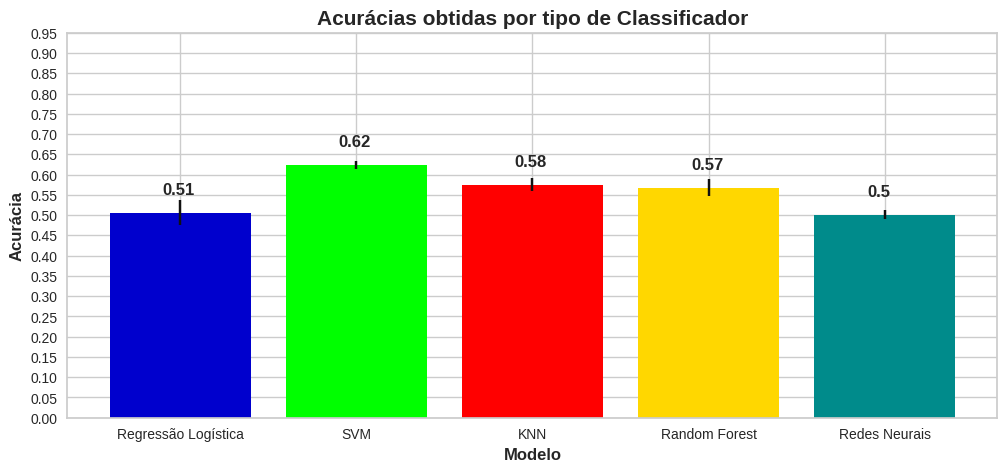

In [ ]:
acuracias = [np.mean(lr_means), np.mean(svm_means), np.mean(knn_means), np.mean(rf_means), np.mean(mlp_means)]
desvios = [np.std(lr_means), np.std(svm_means), np.std(knn_means), np.std(rf_means), np.std(mlp_means)]
#models = ["Logistic Regression", "SVM", "KNN", "Random Forest", "Neural Networks"]

#acuracias = [lr.score(X_test,Y_test), svm.score(X_test,Y_test), knn.score(X_test,Y_test), rf.score(X_test,Y_test), mlp.score(X_test,Y_test)]
modelos = ["Regressão Logística", "SVM", "KNN", "Random Forest", "Redes Neurais"]

fig = plt.figure(figsize = (12, 5))
#plt.bar(modelos, acuracias, color = ['mediumblue', 'lime', 'red', 'gold', 'darkcyan'])
#plt.grid(visible=None, which='minor', axis='y')
plt.bar(modelos, acuracias, yerr=desvios, color = ['mediumblue', 'lime', 'red', 'gold', 'darkcyan'])
plt.ylabel('Acurácia', {'fontsize': 12, 'fontweight': 'bold'})
plt.xlabel('Modelo', {'fontsize': 12, 'fontweight': 'bold'})
plt.title('Acurácias obtidas por tipo de Classificador', {'fontsize': 15, 'fontweight': 'bold'})
plt.yticks(np.arange(0, 1, .05))


for i in range(5):
  plt.text(-0.1 + 1*i, acuracias[i] + 0.045, s = str(round(acuracias[i], 2)), fontweight='bold')
  #plt.text(-0.1 + 1*i, acuracias[i] - 0.3, s = str(round(acuracias[i], 2)), fontweight='bold', color = 'white')

plt.show()

### **Regressão Logística**

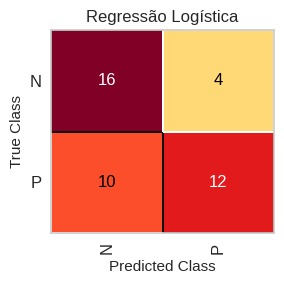

<Axes: title={'center': 'Regressão Logística'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
plt.figure(figsize=(3, 3))
cm = ConfusionMatrix(lr, title = "Regressão Logística", classes = ['N', 'P'])
cm.fit(X_train, Y_train)
cm.score(X_test, Y_test)
cm.show()

In [ ]:
previsoes = lr.predict(X_test)
print(classification_report(previsoes, Y_test))

              precision    recall  f1-score   support

           0       0.80      0.62      0.70        26
           1       0.55      0.75      0.63        16

    accuracy                           0.67        42
   macro avg       0.67      0.68      0.66        42
weighted avg       0.70      0.67      0.67        42



### **SVM**

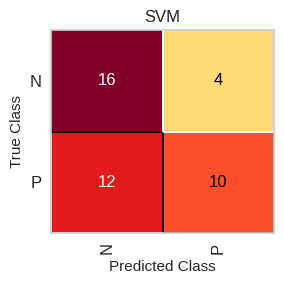

<Axes: title={'center': 'SVM'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
plt.figure(figsize=(3, 3))
cm = ConfusionMatrix(svm, title = "SVM", classes = ['N', 'P'])
cm.fit(X_train, Y_train)
cm.score(X_test, Y_test)
cm.show()

In [ ]:
previsoes = svm.predict(X_test)
print(classification_report(previsoes, Y_test))

              precision    recall  f1-score   support

           0       0.80      0.57      0.67        28
           1       0.45      0.71      0.56        14

    accuracy                           0.62        42
   macro avg       0.63      0.64      0.61        42
weighted avg       0.68      0.62      0.63        42



### **KNN**

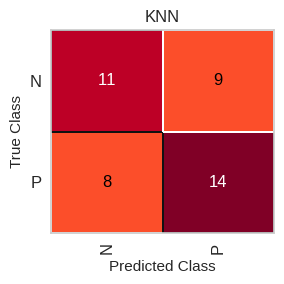

<Axes: title={'center': 'KNN'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
plt.figure(figsize=(3, 3))
cm = ConfusionMatrix(knn, title = "KNN", classes = ['N', 'P'])
cm.fit(X_train, Y_train)
cm.score(X_test, Y_test)
cm.show()

In [ ]:
previsoes = knn.predict(X_test)
print(classification_report(previsoes, Y_test))

              precision    recall  f1-score   support

           0       0.55      0.58      0.56        19
           1       0.64      0.61      0.62        23

    accuracy                           0.60        42
   macro avg       0.59      0.59      0.59        42
weighted avg       0.60      0.60      0.60        42



### **Random Forest**

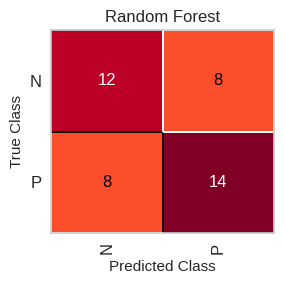

<Axes: title={'center': 'Random Forest'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
plt.figure(figsize=(3, 3))
cm = ConfusionMatrix(rf, title = "Random Forest", classes = ['N', 'P'])
cm.fit(X_train, Y_train)
cm.score(X_test, Y_test)
cm.show()

In [ ]:
previsoes = rf.predict(X_test)
print(classification_report(previsoes, Y_test))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        20
           1       0.64      0.64      0.64        22

    accuracy                           0.62        42
   macro avg       0.62      0.62      0.62        42
weighted avg       0.62      0.62      0.62        42



### **Redes Neurais**

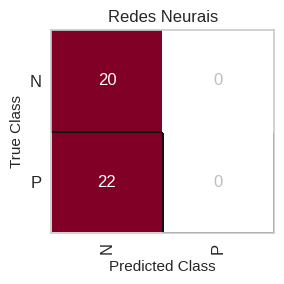

<Axes: title={'center': 'Redes Neurais'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
plt.figure(figsize=(3, 3))
cm = ConfusionMatrix(mlp, title = "Redes Neurais", classes = ['N', 'P'])
cm.fit(X_train, Y_train)
cm.score(X_test, Y_test)
cm.show()

In [ ]:
previsoes = mlp.predict(X_test)
print(classification_report(previsoes, Y_test))

              precision    recall  f1-score   support

           0       1.00      0.48      0.65        42
           1       0.00      0.00      0.00         0

    accuracy                           0.48        42
   macro avg       0.50      0.24      0.32        42
weighted avg       1.00      0.48      0.65        42

